# Pacoes e classes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from funcoes.buscar_dados import Temperature, Load
from funcoes.equacoes import  tabela_equacoes
from funcoes.graficos import plotar_graficos, grid_graficos, grid_graficos_estacoes, plot_metricas_por_hora,plot_heatmap, plot_cv_rmse_percent, plot_cv_rmse_percent_regiao
from funcoes.estacao_ano import estacao_do_ano
from funcoes.funcoes_gerais import  trocar_temp
from funcoes.funcoes_teste import treinamento_estado,treinamento_regioes, treinamento_regioes_formatado
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import gridstatus as gs
from gridstatus import Ercot
import datetime as dt
import re

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# credencias
api_key = '1a69aa1efefb4b73a592faf0e2fbe241'
start_date = "2020-01-01"
end_date = "2025-01-01"

In [3]:
# # Temperatura
# temp = Temperature(api_key)
# df_temp = temp.get_df_temp(start_date, end_date)
# df_temp.to_csv('df_temp2.csv')

# # # Carga
# load = Load(api_key)
# df_load = load.get_df_load(start_date, end_date)
# df_load.to_csv('df_load2.csv')


# Lendo arquivos baixados pela api
filtrar de 2023/09 até 2024/09 todas as horas da carga

In [4]:
# df_t = pd.read_csv('C:/Users/joao.pinheiro/OneDrive - Serena/Área de Trabalho/df_temp.csv')
# df_l = pd.read_csv('C:/Users/joao.pinheiro/OneDrive - Serena/Área de Trabalho/df_load.csv')

df_t = pd.read_csv('C:/Users/Computadores Gamer/OneDrive/Área de Trabalho/dados_tcc/df_temp.csv')
df_l = pd.read_csv('C:/Users/Computadores Gamer/OneDrive/Área de Trabalho/dados_tcc/df_load.csv')

In [5]:
# Tratamentos iniciais
for df in [df_l, df_t]:
    df["interval_start_utc"] = pd.to_datetime(df["interval_start_utc"]).dt.tz_localize(None)
    df["interval_end_utc"] = pd.to_datetime(df["interval_end_utc"], utc=True).dt.tz_localize(None)
    df["publish_time_utc"] = pd.to_datetime(df["publish_time_utc"], utc=True).dt.tz_localize(None)
    
df_t = df_t.drop(columns=["Unnamed: 0"], errors="ignore")
df_l = df_l.drop(columns=["Unnamed: 0", "publish_time_utc_load",'publish_time_utc_tf'], errors="ignore")


df_t = df_t[['interval_start_utc', 'interval_end_utc', 'publish_time_utc', 'coast',
        'east', 'far_west', 'north', 'north_central', 'south_central',
        'southern', 'west', 'hour', 'weekday', 'avg_temp_fahrenheit']]

# Merge
df = pd.merge(
    df_l,
    df_t,
    on=["interval_start_utc", "interval_end_utc"],
    how="inner",
    suffixes=['_carga','_tf']
)

df = trocar_temp(df)
df['publish_time_utc_carga'] = pd.to_datetime(df['publish_time_utc_carga'])


hora = dt.time(10, 30) 
df = df[(df['publish_time_utc_carga'].dt.time == hora)]


# Criacao da coluna de temperatura ponderada pela populacao

In [6]:
# Dicionário de população por região
populacao_regioes = {
    'coast': 7077912,
    'east': 1562486,
    'far_west': 513422,
    'north': 1196299,
    'north_central': 9007898,
    'south_central': 4334575,
    'southern': 2337867,
    'west': 644082
}

# Lista das colunas de temperatura
colunas_temp = [f'{regiao}_tc' for regiao in populacao_regioes]

# Calcula o numerador (temperatura * população por região)
numerador = sum(df[col] * populacao_regioes[col.rsplit('_', 1)[0]] for col in colunas_temp)

# Soma total das populações
denominador = sum(populacao_regioes.values())

# Cria a nova coluna de temperatura ponderada
df['temp_ponderada_pop'] = numerador / denominador

# Teste 1
y= f(x,weekday)= ax2 + bx + c⋅weekday + d

In [7]:
tabela1 = treinamento_estado(df, 'avg_temp_celsius', 'sum_load')
tabela1

,hora,equacao,RMSE Treino,R² Treino,RMSE Teste,R² Teste,RMSE Validação,R² Validação,CV RMSE Médio,CV RMSE DP,CV RMSE %
0,0,y = 91.09x² -2458.00x +55539.49,2145.321536,0.930215,1797.683717,0.948815,2045.598774,0.928700,2153.046441,286.598871,13.311319
1,1,y = -3.31x² +699.87x +33534.08,5790.750785,0.388553,4970.750118,0.526052,5731.672109,0.326714,8736.465964,6706.725406,76.767030
2,2,y = 90.64x² -2452.75x +53475.24,1949.486911,0.916925,1794.035655,0.926439,1922.061659,0.914100,1850.308789,359.706145,19.440331
3,3,y = 89.99x² -2414.65x +52801.55,1891.980038,0.909083,1507.482849,0.938310,2001.389470,0.886560,2140.945882,385.651996,18.013159
4,4,y = 90.31x² -2426.14x +53218.21,1902.069864,0.895098,1502.976947,0.928270,2088.647116,0.859618,2240.327857,377.188174,16.836294
5,5,y = 91.28x² -2487.51x +55279.02,2124.132090,0.852701,1765.091083,0.883687,2337.707508,0.803167,2500.669982,321.673793,12.863504
6,6,y = 88.24x² -2459.14x +58045.52,2758.361342,0.725007,2433.349055,0.745427,2948.716466,0.661367,3148.098679,377.992982,12.007025
7,7,y = 86.05x² -2420.05x +59394.14,3015.427007,0.656595,2704.205505,0.674688,3208.858260,0.590198,3413.079176,461.635587,13.525487
8,8,y = 85.28x² -2400.44x +59979.81,2675.310744,0.759363,2676.406677,0.761493,2448.949018,0.755376,2523.817018,242.662127,9.614886
9,9,y = 90.16x² -2692.10x +64127.14,2473.186707,0.853826,2341.315794,0.868563,2344.564019,0.846501,2383.647035,148.711838,6.238836


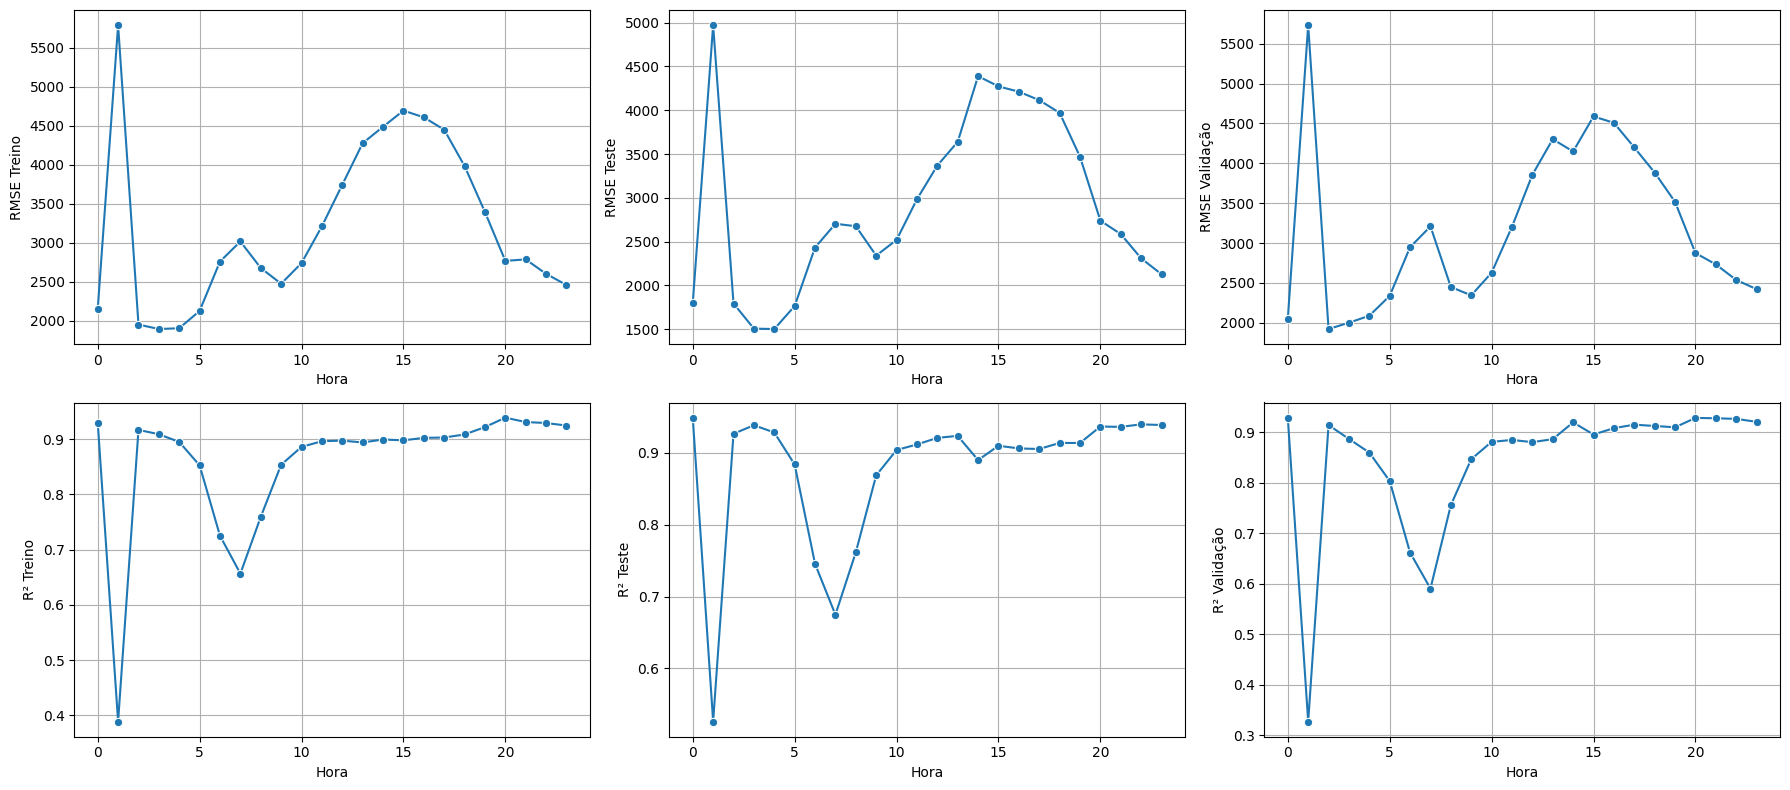

In [8]:
df_resultado_estado1 = treinamento_estado(df, column_x='avg_temp_celsius', column_y='sum_load')
plot_metricas_por_hora(df_resultado_estado1)

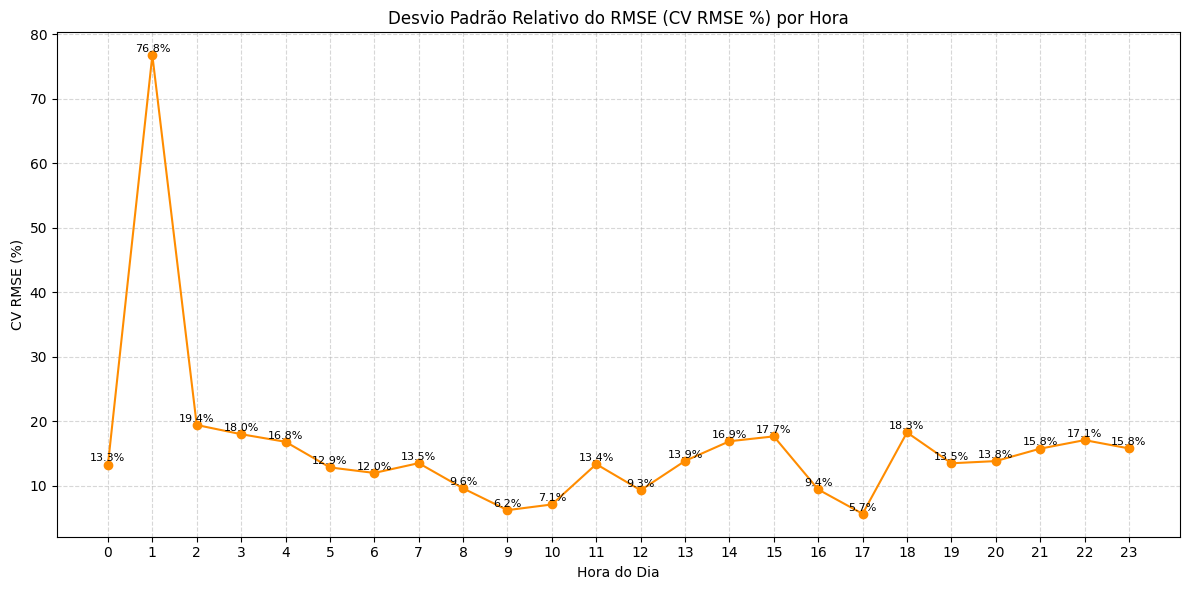

In [9]:
plot_cv_rmse_percent(df_resultado_estado1)

# Teste 2

In [10]:
tabela2 = treinamento_estado(df, 'temp_ponderada_pop', 'sum_load')
tabela2

,hora,equacao,RMSE Treino,R² Treino,RMSE Teste,R² Teste,RMSE Validação,R² Validação,CV RMSE Médio,CV RMSE DP,CV RMSE %
0,0,y = 94.79x² -2645.81x +57320.77,2255.425679,0.922868,1907.850311,0.942350,2312.178644,0.908906,2463.313947,401.014726,16.279481
1,1,y = -5.37x² +778.64x +32598.72,5886.154778,0.368239,5126.587680,0.495869,5878.687250,0.291732,9337.705299,7401.364700,79.263207
2,2,y = 92.93x² -2605.69x +55073.33,2061.293480,0.907122,1970.092757,0.911293,2069.638278,0.900402,2016.932339,424.547429,21.049166
3,3,y = 92.24x² -2573.97x +54488.13,1980.506073,0.900376,1650.871587,0.926016,2230.726688,0.859073,2382.505132,414.478305,17.396743
4,4,y = 91.52x² -2556.65x +54743.69,1984.309602,0.885830,1635.969011,0.915014,2309.771232,0.828320,2456.577774,430.065932,17.506709
5,5,y = 92.85x² -2640.58x +57064.25,2158.008100,0.847965,1826.333340,0.875476,2515.468756,0.772094,2651.660849,393.907597,14.855127
6,6,y = 90.19x² -2629.25x +60028.95,2739.284805,0.728797,2441.771174,0.743662,3048.098596,0.638157,3235.885514,486.132590,15.023170
7,7,y = 89.08x² -2634.34x +61770.04,2954.619103,0.670305,2663.992408,0.684291,3255.550386,0.578185,3442.141709,514.719180,14.953457
8,8,y = 89.48x² -2666.00x +62846.42,2620.862629,0.769058,2533.067244,0.786356,2426.336713,0.759873,2499.980324,233.320930,9.332911
9,9,y = 94.37x² -2959.14x +67199.49,2492.425756,0.851543,2286.939643,0.874597,2389.761897,0.840526,2426.967028,164.543974,6.779819


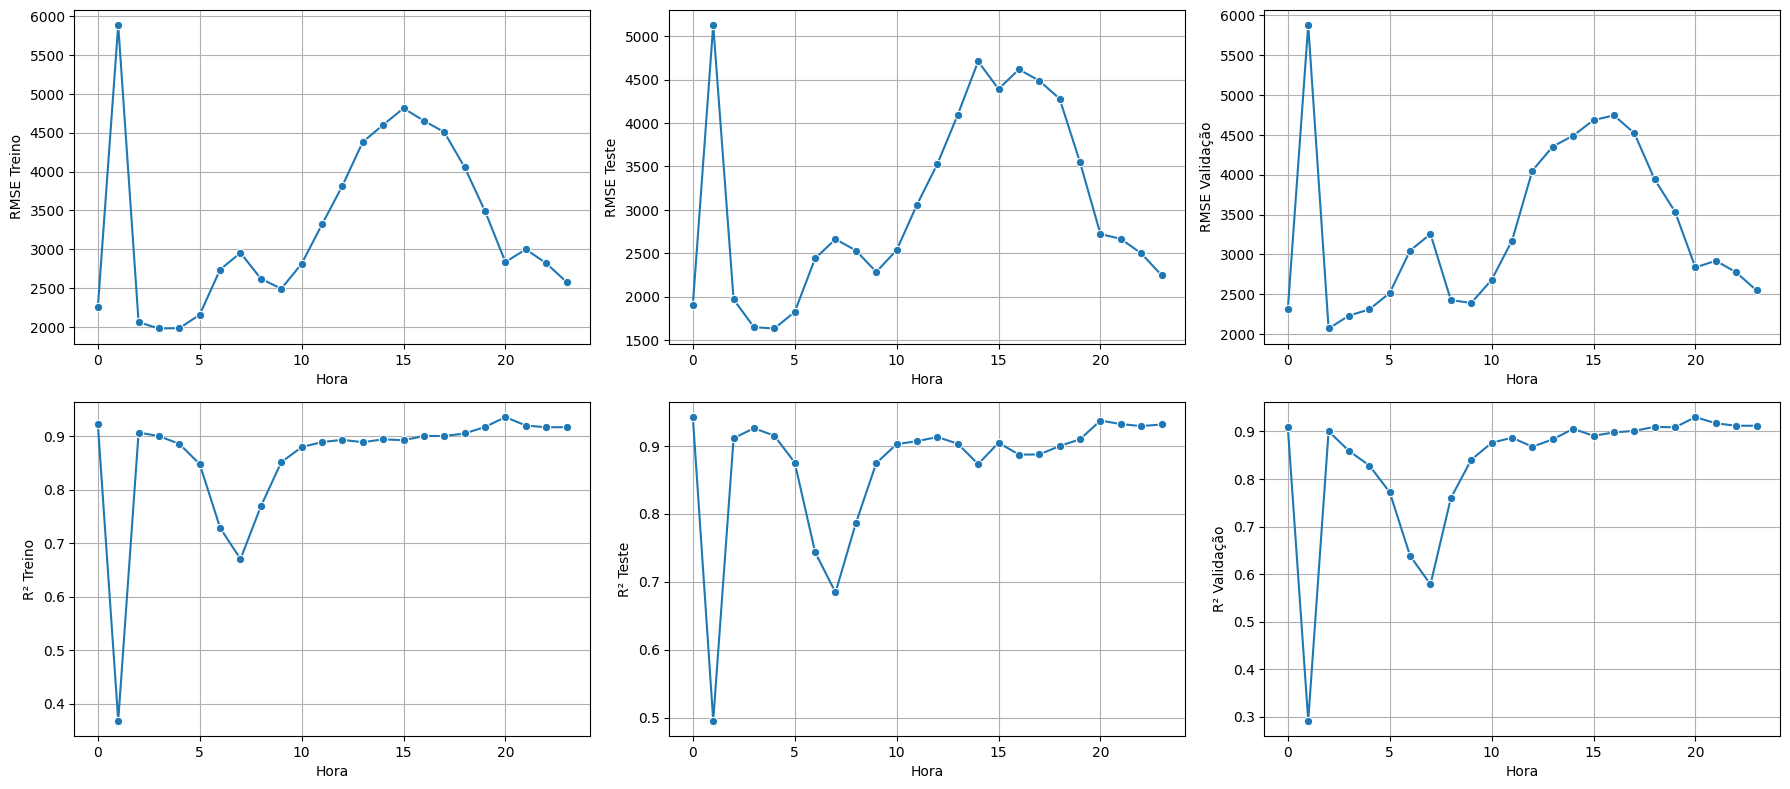

In [11]:
df_resultado_estado2 = treinamento_estado(df, column_x='temp_ponderada_pop', column_y='sum_load')
plot_metricas_por_hora(df_resultado_estado2)

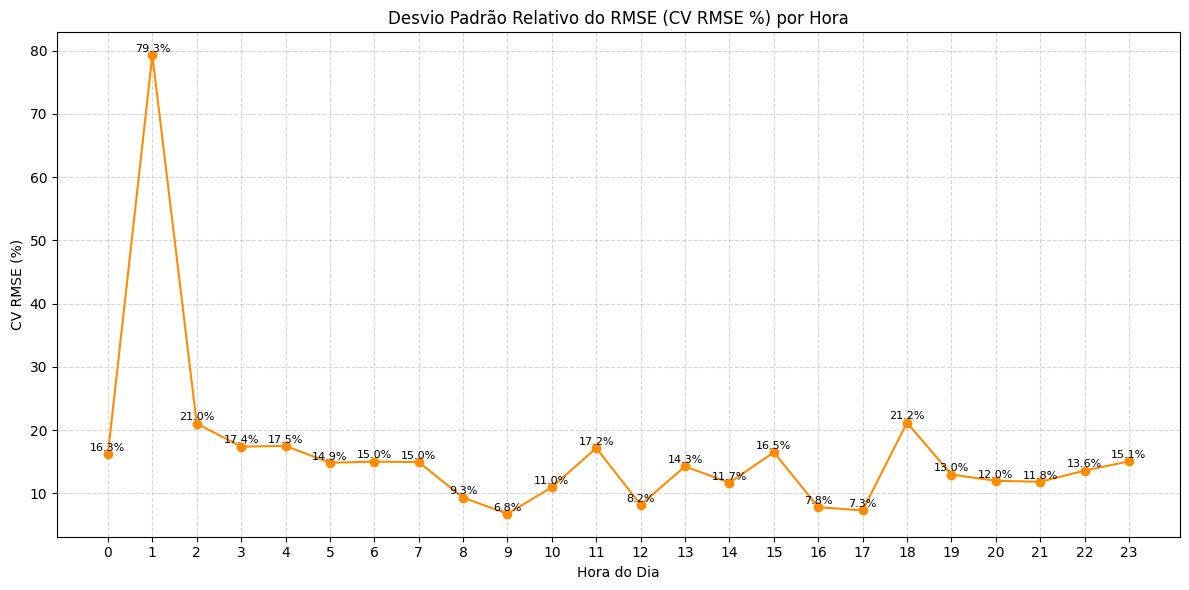

In [12]:
plot_cv_rmse_percent(df_resultado_estado2)

# Teste 3 , uma tabela para cada regiao

In [13]:
tabela_formatada3 = treinamento_regioes_formatado(df)
tabela_formatada3

,hora,região,equação,RMSE Treino,R² Treino,RMSE Teste,R² Teste,RMSE Validação,R² Validação,CV RMSE Médio,CV RMSE DP,CV RMSE %
0,0,coast,y = 26.22x² -751.19x +15227.30,790.679255,0.873037,659.070029,0.910780,662.042813,0.901513,688.338827,85.327162,12.396099
1,0,east,y = 3.78x² -109.71x +2119.17,147.100806,0.731911,120.935859,0.789585,144.344116,0.693243,151.164126,18.805511,12.440459
2,0,far_west,y = 2.05x² -48.23x +6414.37,312.390841,0.425385,371.912603,0.379604,279.991057,0.362469,271.420629,14.371334,5.294857
3,0,north,y = 2.30x² -51.29x +1447.61,130.772009,0.749407,128.173728,0.737005,128.782265,0.723511,126.625458,18.522021,14.627407
4,0,north_central,y = 28.88x² -784.99x +15438.29,1050.269277,0.870654,952.232507,0.884840,999.829208,0.869680,1066.142008,157.610749,14.783279
...,...,...,...,...,...,...,...,...,...,...,...,...
187,23,north,y = 2.11x² -44.49x +1422.58,137.563135,0.768996,137.744655,0.735764,130.855457,0.773796,124.339813,27.176793,21.856872
188,23,north_central,y = 29.07x² -794.26x +16173.80,1198.684409,0.863143,996.975803,0.902083,1107.751792,0.870408,1091.490314,199.397307,18.268353
189,23,south_central,y = 15.37x² -401.52x +9152.42,661.813151,0.862036,629.086369,0.861750,719.492296,0.826594,732.436545,82.232831,11.227298
190,23,southern,y = 8.94x² -277.59x +5260.78,229.605593,0.896231,219.046707,0.897711,221.356705,0.895851,216.151832,15.834931,7.325837


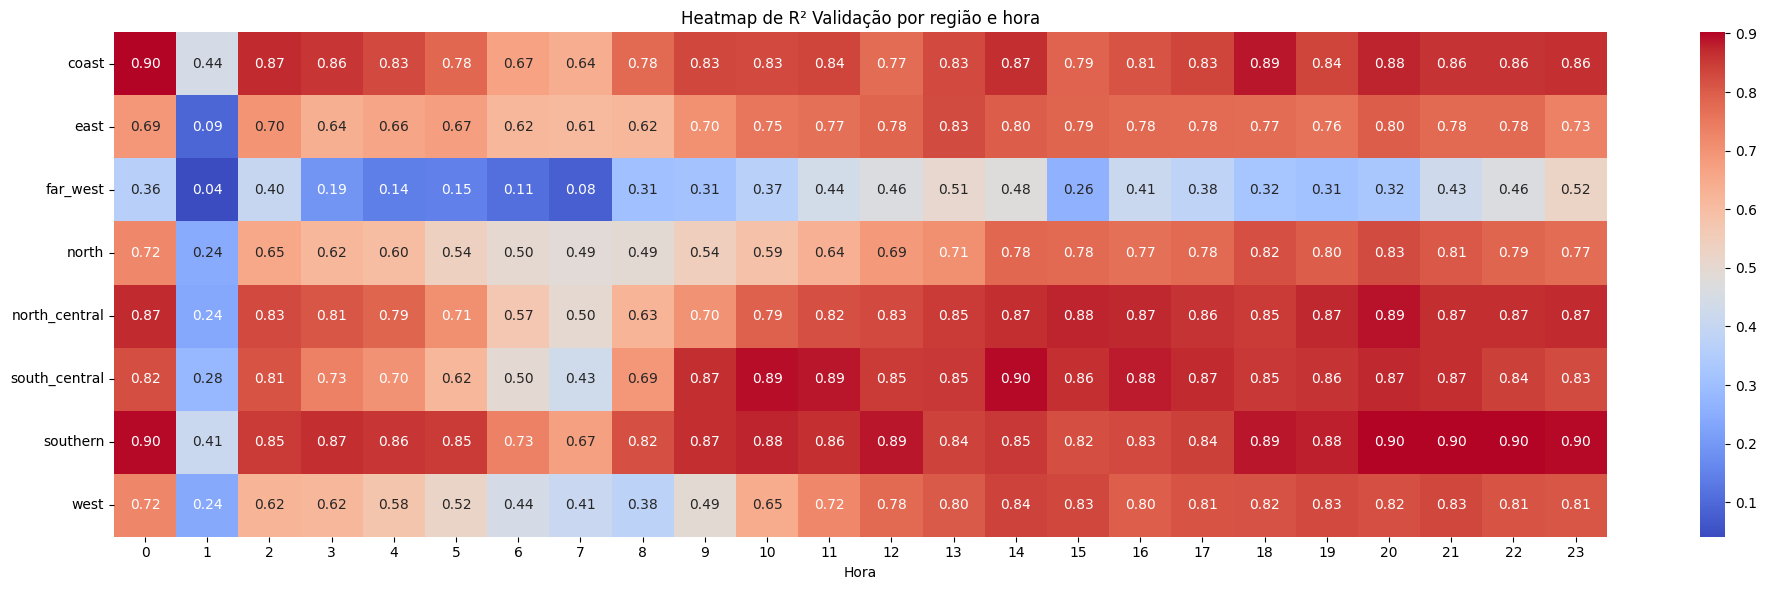

In [14]:
plot_heatmap(tabela_formatada3, 'R² Validação')

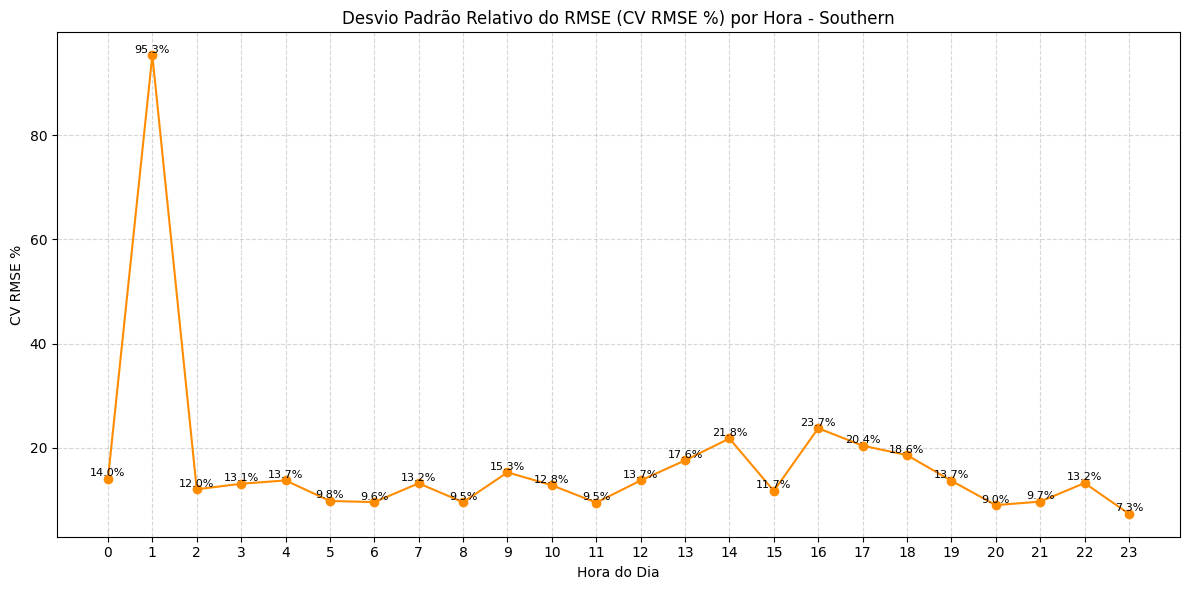

In [20]:
plot_cv_rmse_percent_regiao(tabela_formatada3, 'southern')